# Dog Breed Identification with Data Augmentation

In this Notebook, I am going to use again the pre-trained Xception model to determine the breed of the dogs in the dataset, but now I am also going to use data augmentation.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

import glob
from functools import partial

In [2]:
from google.colab import drive
# Accessing My Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load and prepare the training data

In [3]:
INPUT_PATH = "drive/My Drive/Dog Breed Identification/"
TRAIN_ROOT_PATH = INPUT_PATH + "train/"
TEST_ROOT_PATH = INPUT_PATH + "test/"

In [4]:
# read the labels dataset
labels = pd.read_csv(INPUT_PATH + "labels.csv")
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [5]:
labels.shape

(10222, 2)

In [6]:
# training settings
BATCH_SIZE = 32
DATASET_SIZE = len(labels["breed"])
NUM_CLASSES = labels["breed"].nunique()

In [7]:
# tf.data.Dataset settings
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [8]:
# Map dog breeds to numbers
label_to_num = dict(zip(sorted(list(labels["breed"].unique())),
                        range(NUM_CLASSES)))

In [9]:
# Split the training set to training and validation sets
x_train, x_valid, y_train, y_valid = train_test_split(labels["id"],
                                                labels["breed"], 
                                                stratify=labels["breed"],
                                                test_size=0.2,
                                                random_state=42)

In [10]:
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((8177,), (2045,), (8177,), (2045,))

In [11]:
def get_image_path(image_id, extension=".jpg"):
    """
    Given the id of an image return its directory path
    """
    return TRAIN_ROOT_PATH + image_id + extension

def load_and_decode_image(path, channels=3):
    """
    Read a JPEG-encoded image from path and decode it to a uint8 tensor
    """
    image = tf.io.read_file(path)
    return tf.image.decode_jpeg(image, channels=channels)

def get_label_num(label_name):
    """
    Represent labels with numbers 
    """
    return label_to_num.get(label_name)

def get_label_from_num(num):
    """
    Get label from numerical representation 
    """
    return list(label_to_num.keys())[list(label_to_num.values()).index(num)]

In [12]:
def get_pair_ds(images, labels):
    """
    Load images and labels to datasets
    """
    path_ds = tf.data.Dataset.from_tensor_slices(list(map(get_image_path, images.values)))
    image_ds = path_ds.map(load_and_decode_image, num_parallel_calls=AUTOTUNE)
    label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(list(map(get_label_num, labels.values)), tf.int64))
    return image_ds, label_ds

def apply_ds(image_ds, label_ds):
    """
    Combine image and label datasets
    """
    ds = tf.data.Dataset.zip((image_ds, label_ds))
    return ds

# load the training and validation images to datasets
train_ds = apply_ds(*get_pair_ds(x_train, y_train))
valid_ds = apply_ds(*get_pair_ds(x_valid, y_valid))

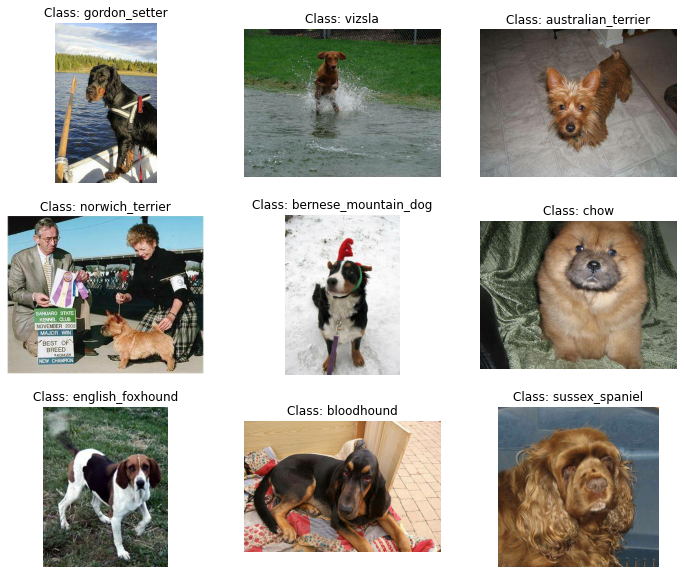

In [13]:
# plot the first 9 images of the training dataset
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_ds.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(get_label_from_num(label)))
    plt.axis("off")

plt.show()

In [14]:
IMG_SIZE = 224

def preprocess(image, label):
    resized_image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

In [15]:
train_set = train_ds.shuffle(1000).repeat()
train_set = train_set.map(preprocess).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
valid_set = valid_ds.map(preprocess).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

### Data augmentation

In [16]:
data_augmentation = keras.Sequential([
    keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

Let's repeatedly apply these layers to the same image and see the result.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


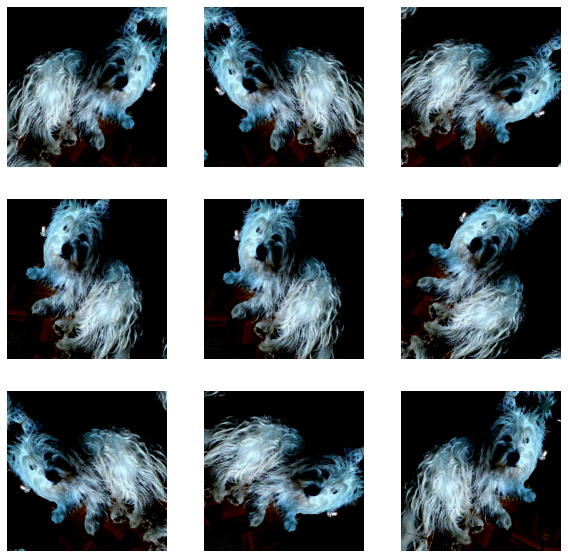

In [17]:
for image, _ in train_set.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0])
    plt.axis('off');

### Train the model

In [18]:
# Create the base model from the pre-trained model Xception
IMG_SHAPE = (IMG_SIZE, IMG_SIZE) + (3,)
base_model = keras.applications.xception.Xception(input_shape=IMG_SHAPE,
                                                  weights="imagenet",
                                                  include_top=False)

This feature extractor converts each 224x224x3 image into a 7x7x2048 block of features. Let's see what it does to an example batch of images:

In [19]:
image_batch, label_batch = next(iter(train_set))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 2048)


In this step, I will freeze the convolutional base created from the previous step to use as a feature extractor. Additionally, I add a classifier on top of it and train the top-level classifier.

In [20]:
# freeze weights of pretrained layers
base_model.trainable = False

In [21]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

To generate predictions from the block of features, I average over the spatial 7x7 spatial locations, using a tf.keras.layers.GlobalAveragePooling2D layer to convert the features to a single 2048-element vector per image.


In [22]:
global_average_layer = keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


Apply a keras.layers.Dense layer to convert these features into a single prediction per image.

In [23]:
prediction_layer = keras.layers.Dense(NUM_CLASSES, activation="softmax")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 120)


Build a model by chaining together the data augmentation, base_model and feature extractor layers using the Keras Functional API. We should not forget to use training=False as the model contains a BatchNormalization layer.

In [24]:
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = keras.Model(inputs, outputs)

In [25]:
base_learning_rate = 0.0001
model.compile(optimizer=keras.optimizers.Adam(lr=base_learning_rate),
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [26]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 120)               245880    
Total params: 21,107,360
Trainable params: 245,880
Non-trainable params: 20,861,480
____________________________________

In [27]:
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * DATASET_SIZE / BATCH_SIZE),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * DATASET_SIZE / BATCH_SIZE),
                    epochs=5)

Epoch 1/5
239/239 [==============================] - 27s 112ms/step - loss: 4.1004 - accuracy: 0.1817 - val_loss: 3.0688 - val_accuracy: 0.5731
Epoch 2/5
239/239 [==============================] - 25s 106ms/step - loss: 2.8252 - accuracy: 0.4911 - val_loss: 2.0174 - val_accuracy: 0.7207
Epoch 3/5
239/239 [==============================] - 26s 109ms/step - loss: 2.1118 - accuracy: 0.5919 - val_loss: 1.4622 - val_accuracy: 0.7666
Epoch 4/5
239/239 [==============================] - 25s 106ms/step - loss: 1.7525 - accuracy: 0.6262 - val_loss: 1.1744 - val_accuracy: 0.7852
Epoch 5/5
239/239 [==============================] - 26s 107ms/step - loss: 1.5532 - accuracy: 0.6487 - val_loss: 1.0097 - val_accuracy: 0.7939


In [28]:
# un-freeze the weights
base_model.trainable = True

In [29]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  132


In [30]:
model.compile(optimizer=keras.optimizers.Adam(lr=base_learning_rate/10),
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [31]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 120)               245880    
Total params: 21,107,360
Trainable params: 9,724,224
Non-trainable params: 11,383,136
__________________________________

In [32]:
# callbacks
checkpoint_cb = keras.callbacks.ModelCheckpoint("drive/My Drive/Dog Breed Identification/best_model.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=8,
                                                  monitor="val_accuracy")
callbacks = [checkpoint_cb, early_stopping_cb]

In [33]:
# train model with early stopping
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * DATASET_SIZE / BATCH_SIZE),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * DATASET_SIZE / BATCH_SIZE),
                    epochs=100, callbacks=callbacks)

Epoch 1/100
239/239 [==============================] - 35s 147ms/step - loss: 1.1616 - accuracy: 0.6735 - val_loss: 0.6827 - val_accuracy: 0.8032
Epoch 2/100
239/239 [==============================] - 36s 151ms/step - loss: 1.0477 - accuracy: 0.6866 - val_loss: 0.6605 - val_accuracy: 0.8005
Epoch 3/100
239/239 [==============================] - 36s 150ms/step - loss: 0.9878 - accuracy: 0.7117 - val_loss: 0.6487 - val_accuracy: 0.8065
Epoch 4/100
239/239 [==============================] - 36s 151ms/step - loss: 0.9402 - accuracy: 0.7220 - val_loss: 0.6392 - val_accuracy: 0.8078
Epoch 5/100
239/239 [==============================] - 36s 151ms/step - loss: 0.9395 - accuracy: 0.7237 - val_loss: 0.6344 - val_accuracy: 0.8078
Epoch 6/100
239/239 [==============================] - 33s 140ms/step - loss: 0.8999 - accuracy: 0.7305 - val_loss: 0.6356 - val_accuracy: 0.8125
Epoch 7/100
239/239 [==============================] - 36s 152ms/step - loss: 0.8608 - accuracy: 0.7364 - val_loss: 0.6318 -

### Load and prepare the test data

In [34]:
# load the best model
best_model = keras.models.load_model("drive/My Drive/Dog Breed Identification/best_model.h5")

In [35]:
# read the submission csv
submission_df = pd.read_csv(INPUT_PATH + "sample_submission.csv")
submission_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
1,00102ee9d8eb90812350685311fe5890,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
2,0012a730dfa437f5f3613fb75efcd4ce,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
3,001510bc8570bbeee98c8d80c8a95ec1,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333

In [36]:
submission_df.shape

(10357, 121)

In [37]:
def get_image_path_test(image_id, extension=".jpg"):
    """
    Given the id of an image return its directory path
    """
    return TEST_ROOT_PATH + image_id + extension

def preprocess_test(image, img_size=IMG_SIZE):
    resized_image = tf.image.resize(image, [img_size, img_size])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image

In [38]:
test_ids = submission_df['id']

# load and decode test images
path_ds = tf.data.Dataset.from_tensor_slices(list(map(get_image_path_test, test_ids.values)))
test_ds = path_ds.map(load_and_decode_image, num_parallel_calls=AUTOTUNE)

# preprocess, batch, and prefetch the test dataset
test_set = test_ds.map(preprocess_test).batch(BATCH_SIZE).prefetch(1)

### Predictions and submission to Kaggle

Now, having trained and loaded the best model we can use it to make predictions:

In [39]:
y_proba = best_model.predict(test_set)

In [40]:
for breed in labels['breed'].unique():
    submission_df[breed] = y_proba[:, get_label_num(breed)]

In [41]:
submission_df.head(2)

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.000003,0.000003,2.115070e-07,2.271381e-07,1.138603e-07,3.036686e-07,5.701728e-08,1.961440e-07,4.522967e-07,2.278971e-07,3.072529e-07,1.342002e-07,3.947885e-07,2.862193e-04,7.311020e-08,0.000001,5.931023e-07,4.953747e-08,0.000001,0.000006,7.169120e-08,0.000005,0.000126,0.000002,1.787497e-06,2.119791e-07,7.502117e-08,3.797882e-07,5.114624e-08,0.000036,7.017297e-07,5.335144e-07,0.000001,0.000009,2.245934e-07,3.983891e-07,4.657080e-07,1.683770e-07,8.594709e-08,...,7.773001e-08,2.292101e-08,4.197743e-07,1.599712e-07,0.014946,0.039665,8.820960e-08,0.000168,0.000005,1.037644e-07,1.043584e-07,5.350264e-08,0.000014,0.000016,5.800453e-07,7.081301e-08,5.438884e-08,5.616191e-08,6.103207e-07,0.000010,0.003129,0.000001,2.126826e-07,8.053312e-08,4.462376e-07,2.146534e-07,1.128414e-07,1.893797e-07,0.000001,0.000012,9.000451e-07,0.000002,9.039258e-08,2.245275e-07,2.831415e-07,5.035562e-07,9.315458e-08,9.737081e-07,1.796698e-07,0.000003
1,00102ee9d8eb90812350685311fe5890,0.000010,0.000002,3.749931e-06,1.729069e-05,2.232010e-06,3.252516e-05,3.370046e-07,7.839445e-06,4.640310e-07,2.517105e-06,1.666181e-05,5.557117e-06,3.173817e-06,8.971180e-07,1.152991e-06,0.000017,4.403193e-05,1.350031e-06,0.000009,0.000007,9.257143e-06,0.000002,0.000002,0.000004,8.285108e-07,2.541257e-07,2.215903e-06,1.308629e-05,6.504548e-06,0.000017,6.781125e-03,1.553117e-06,0.000004,0.000156,1.649345e-05,5.045095e-07,2.647056e-06,2.302249e-06,3.049658e-06,...,2.804149e-05,5.815134e-06,8.971505e-05,5.702193e-06,0.000005,0.000005,1.808206e-05,0.005141,0.000005,3.085751e-06,1.561437e-06,2.129600e-06,0.000002,0.000003,9.737372e-01,1.511997e-04,6.982782e-06,2.791367e-06,6.841602e-07,0.000007,0.000003,0.002182,4.466808e-07,3.177933e-06,7.238190e-06,4.338417e-04,7.973655e-07,3.794362e-06,0.000417,0.000003,4.346884e-05,0.000004,7.148312e-06,5.764978e-07,1.107850e-06,9.931259e-07,9.943504e-05,4.070581e-06,8.824903e-07,0.000004


In [42]:
submission_df.to_csv('drive/My Drive/Dog Breed Identification/tl_with_data_augm_preds.csv', index=None)

This submission leads to a score of 0.61053 in the public leaderboard of Kaggle (top 60%). Much better than without data augmentation (0.84991), but can we do even better than that? Let's give it a try...

References:


*   https://www.kaggle.com/wakamezake/tf-keras-dog-breed-identification
*   https://www.tensorflow.org/tutorials/images/transfer_learning#use_data_augmentation
*   https://github.com/ageron/handson-ml2/blob/master/14_deep_computer_vision_with_cnns.ipynb
*   Aurélien Géron - "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow", O'Reilly Media
